In [1]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [2]:
DATA_PATH = "/kaggle/input/speech-command-dataset/go_left_right_stop.json"
SAVED_MODEL_PATH = "CNN_Journal.h5"
EPOCHS = 300
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 0.00001

In [3]:
"""Loads training dataset from json file.
:param data_path (str): Path to json file containing data
:return X (ndarray): Inputs
:return y (ndarray): Targets
"""
with open(DATA_PATH, "r") as fp:
    data = json.load(fp)

X = np.array(data["MFCCs"])
y = np.array(data["labels"])


In [4]:
test_size=0.2
validation_size=0.20

# membuat train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=1)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

In [5]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        self.test_data = X_test, y_test

    def on_epoch_end(self, epoch, logs):
        X_test, y_test = self.test_data
        loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
        logs['test_accuracy'] = acc

## CNN

In [6]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
loss="sparse_categorical_crossentropy"
LEARNING_RATE = 0.00001

model = tf.keras.models.Sequential()

# 1st conv layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 2nd conv layer
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu',))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
tf.keras.layers.Dropout(0.3)

model.add(tf.keras.layers.Dense(128, activation='relu'))
tf.keras.layers.Dropout(0.3)

model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(4, activation='softmax'))
optimiser = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile model
model.compile(optimizer=optimiser,
              loss=loss,
              metrics=["accuracy"])

# print model parameters on console
model.summary()

2023-02-10 12:02:33.875705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 12:02:33.969186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 12:02:33.969974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 12:02:33.971911: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 4, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 1, 128)         32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0

In [7]:
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=TestCallback(X_test, y_test))

Epoch 1/300


2023-02-10 12:02:37.021961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-10 12:02:38.448893: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


560/560 [==============================] - 10s 4ms/step - loss: 1.9830 - accuracy: 0.4760 - val_loss: 0.9222 - val_accuracy: 0.6315
Epoch 2/300
560/560 [==============================] - 2s 4ms/step - loss: 0.7971 - accuracy: 0.6914 - val_loss: 0.7298 - val_accuracy: 0.7155
Epoch 3/300
560/560 [==============================] - 2s 4ms/step - loss: 0.5998 - accuracy: 0.7753 - val_loss: 0.5719 - val_accuracy: 0.7812
Epoch 4/300
560/560 [==============================] - 3s 5ms/step - loss: 0.4834 - accuracy: 0.8277 - val_loss: 0.4750 - val_accuracy: 0.8280
Epoch 5/300
560/560 [==============================] - 2s 4ms/step - loss: 0.4074 - accuracy: 0.8587 - val_loss: 0.4100 - val_accuracy: 0.8593
Epoch 6/300
560/560 [==============================] - 2s 4ms/step - loss: 0.3522 - accuracy: 0.8781 - val_loss: 0.3777 - val_accuracy: 0.8629
Epoch 7/300
560/560 [==============================] - 2s 4ms/step - loss: 0.3115 - accuracy: 0.8952 - val_loss: 0.3401 - val_accuracy: 0.8843
Epoch 8/30

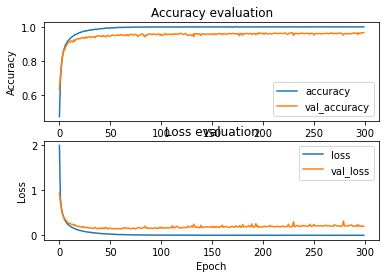

In [8]:
fig, axs = plt.subplots(2)

# create accuracy subplot
axs[0].plot(history.history["accuracy"], label="accuracy")
axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy evaluation")

# create loss subplot
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history['val_loss'], label="val_loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss evaluation")

plt.show()

In [9]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

print(input_shape)
# save model
# model.save(SAVED_MODEL_PATH)

88/88 [==============================] - 0s 2ms/step - loss: 0.1777 - accuracy: 0.9611

Test loss: 0.1777481734752655, test accuracy: 96.10575437545776
(44, 13, 1)


Text(69.0, 0.5, 'Truth')

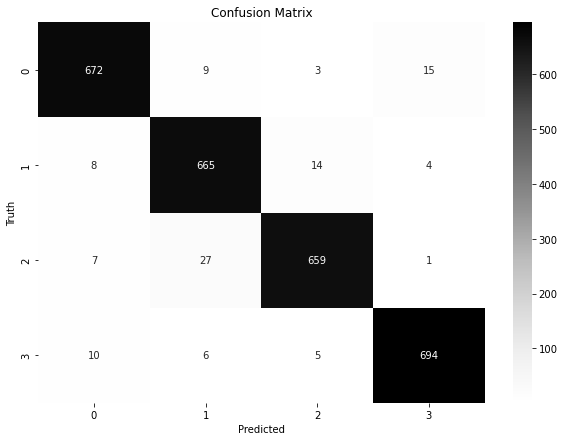

In [10]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, cmap='Greys', annot=True, fmt='d')
plt.title('Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('Truth')

## LSTM 

In [11]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
loss="sparse_categorical_crossentropy"
LEARNING_RATE = 0.00001


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=input_shape))

model.add(tf.keras.layers.Reshape((1, X_train.shape[1]*X_train.shape[2])))

# 1st LSTM layer
model.add(tf.keras.layers.LSTM(32, return_sequences=True))

# 2nd LSTM layer
model.add(tf.keras.layers.LSTM(64, return_sequences=True))

# 3rd LSTM layer
model.add(tf.keras.layers.LSTM(128))

# dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))
tf.keras.layers.Dropout(0.3)

model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

model.add(tf.keras.layers.Dense(32, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(4, activation='softmax'))
optimiser = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile model
model.compile(optimizer=optimiser,
              loss=loss,
              metrics=["accuracy"])

# print model parameters on console
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 572)               0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 572)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 32)             77440     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [12]:
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=TestCallback(X_test, y_test))

Epoch 1/300
560/560 [==============================] - 8s 8ms/step - loss: 1.3854 - accuracy: 0.3169 - val_loss: 1.3842 - val_accuracy: 0.3738
Epoch 2/300
560/560 [==============================] - 3s 6ms/step - loss: 1.3822 - accuracy: 0.4009 - val_loss: 1.3790 - val_accuracy: 0.4381
Epoch 3/300
560/560 [==============================] - 4s 7ms/step - loss: 1.3743 - accuracy: 0.4178 - val_loss: 1.3664 - val_accuracy: 0.4511
Epoch 4/300
560/560 [==============================] - 3s 6ms/step - loss: 1.3551 - accuracy: 0.4242 - val_loss: 1.3366 - val_accuracy: 0.4538
Epoch 5/300
560/560 [==============================] - 3s 6ms/step - loss: 1.3138 - accuracy: 0.4470 - val_loss: 1.2780 - val_accuracy: 0.4770
Epoch 6/300
560/560 [==============================] - 4s 7ms/step - loss: 1.2437 - accuracy: 0.4908 - val_loss: 1.1947 - val_accuracy: 0.5150
Epoch 7/300
560/560 [==============================] - 4s 7ms/step - loss: 1.1553 - accuracy: 0.5273 - val_loss: 1.1034 - val_accuracy: 0.5431

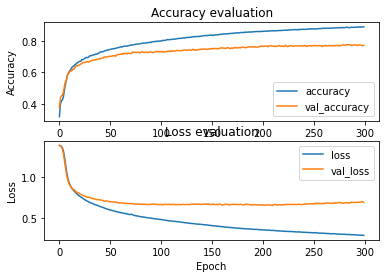

In [13]:
fig, axs = plt.subplots(2)

# create accuracy subplot
axs[0].plot(history.history["accuracy"], label="accuracy")
axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy evaluation")

# create loss subplot
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history['val_loss'], label="val_loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss evaluation")

plt.show()

In [14]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

print(input_shape)
# save model
# model.save(SAVED_MODEL_PATH)

88/88 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.7667

Test loss: 0.7101078033447266, test accuracy: 76.670241355896
(44, 13, 1)


Text(69.0, 0.5, 'Truth')

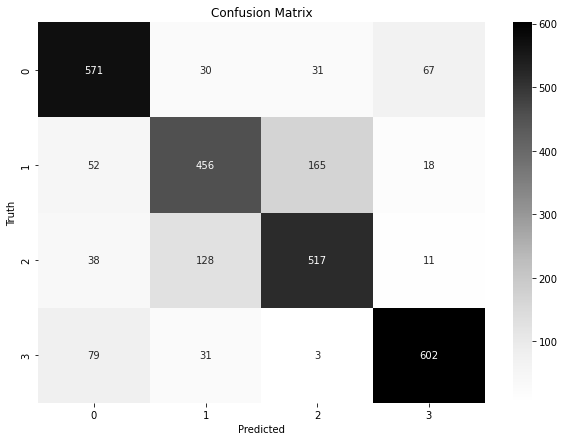

In [15]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, cmap='Greys', annot=True, fmt='d')
plt.title('Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('Truth')

## ANN

In [16]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
loss="sparse_categorical_crossentropy"
LEARNING_RATE = 0.00001


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=input_shape))

# 1st dense layer
model.add(tf.keras.layers.Dense(256, activation='relu'))
tf.keras.layers.Dropout(0.3)

# 2nd dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))
tf.keras.layers.Dropout(0.3)

# 3rd dense layer
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(4, activation='softmax'))
optimiser = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile model
model.compile(optimizer=optimiser,
              loss=loss,
              metrics=["accuracy"])

# print model parameters on console
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 572)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               146688    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
Total params: 188,100
Trainable params: 188,100
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=TestCallback(X_test, y_test))

Epoch 1/300
560/560 [==============================] - 2s 3ms/step - loss: 19.6377 - accuracy: 0.3384 - val_loss: 8.6475 - val_accuracy: 0.4475
Epoch 2/300
560/560 [==============================] - 2s 3ms/step - loss: 6.2887 - accuracy: 0.5093 - val_loss: 5.5283 - val_accuracy: 0.5453
Epoch 3/300
560/560 [==============================] - 2s 3ms/step - loss: 4.2567 - accuracy: 0.6023 - val_loss: 4.3727 - val_accuracy: 0.6137
Epoch 4/300
560/560 [==============================] - 1s 3ms/step - loss: 3.2976 - accuracy: 0.6548 - val_loss: 3.6703 - val_accuracy: 0.6423
Epoch 5/300
560/560 [==============================] - 1s 2ms/step - loss: 2.6583 - accuracy: 0.6924 - val_loss: 3.0914 - val_accuracy: 0.6941
Epoch 6/300
560/560 [==============================] - 1s 2ms/step - loss: 2.2089 - accuracy: 0.7244 - val_loss: 2.7203 - val_accuracy: 0.7039
Epoch 7/300
560/560 [==============================] - 2s 3ms/step - loss: 1.9043 - accuracy: 0.7465 - val_loss: 2.3992 - val_accuracy: 0.726

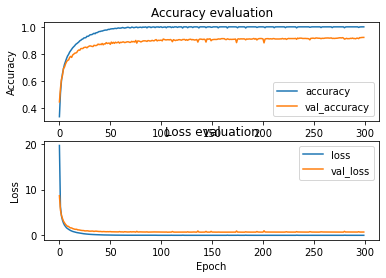

In [18]:
fig, axs = plt.subplots(2)

# create accuracy subplot
axs[0].plot(history.history["accuracy"], label="accuracy")
axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy evaluation")

# create loss subplot
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history['val_loss'], label="val_loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss evaluation")

plt.show()

In [19]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

print(input_shape)
# save model
# model.save(SAVED_MODEL_PATH)

88/88 [==============================] - 0s 2ms/step - loss: 0.7017 - accuracy: 0.9185

Test loss: 0.7016589641571045, test accuracy: 91.85423254966736
(44, 13, 1)


Text(69.0, 0.5, 'Truth')

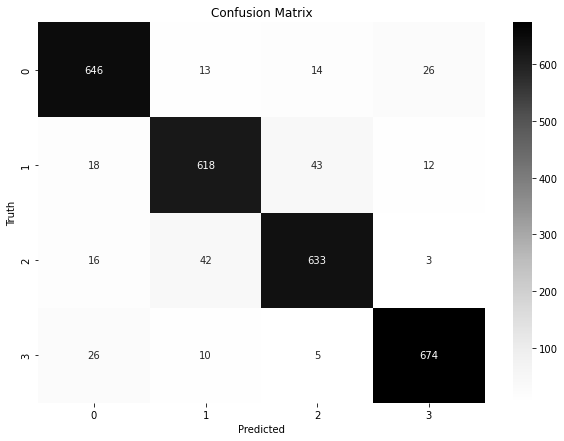

In [20]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, cmap='Greys', annot=True, fmt='d')
plt.title('Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('Truth')